In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection  import *
import sklearn.preprocessing
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr,spearmanr


In [3]:
data=pd.read_csv('bike_train.csv')

In [4]:
data.head()

,ID,season,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,FALL,3,NO HOLIDAY,MON,WORKING DAY,GOOD,24.34,89,0.0000,1
1,2,FALL,3,NO HOLIDAY,WED,WORKING DAY,GOOD,20.42,68,8.9981,1
2,3,FALL,3,NO HOLIDAY,TUE,WORKING DAY,RAIN/SNOW/STORM,18.46,94,19.9995,1
3,4,FALL,4,NO HOLIDAY,SUN,NO WORKING DAY,GOOD,13.56,77,15.0013,1
4,5,FALL,5,NO HOLIDAY,SUN,NO WORKING DAY,RAIN/SNOW/STORM,22.38,83,12.9980,1


In [5]:
data.describe()

,ID,hr,temp,hum,windspeed,cnt
count,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000
mean,6517.500000,11.508977,16.343985,62.731548,12.755648,189.631809
std,3762.736039,6.908892,9.419505,19.342086,8.219009,181.837063
min,1.000000,0.000000,-7.020000,0.000000,0.000000,1.000000
25%,3259.250000,6.000000,8.660000,48.000000,7.001500,40.000000
50%,6517.500000,12.000000,16.500000,63.000000,12.998000,142.000000
75%,9775.750000,17.000000,24.340000,78.000000,16.997900,281.000000
max,13034.000000,23.000000,41.000000,100.000000,56.996900,977.000000


In [15]:
data.isna().sum() ## No missing values

ID            0
season        0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
hum           0
windspeed     0
cnt           0
dtype: int64

In [16]:
data.corr()

,ID,hr,temp,hum,windspeed,cnt
ID,1.000000,0.515175,0.423913,-0.352464,0.104483,0.920027
hr,0.515175,1.000000,0.137854,-0.279930,0.139965,0.396791
temp,0.423913,0.137854,1.000000,-0.064423,-0.022881,0.403676
hum,-0.352464,-0.279930,-0.064423,1.000000,-0.288457,-0.321290
windspeed,0.104483,0.139965,-0.022881,-0.288457,1.000000,0.090753
cnt,0.920027,0.396791,0.403676,-0.321290,0.090753,1.000000


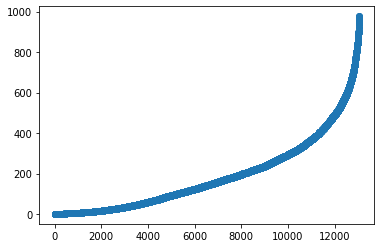

In [17]:
plt.scatter(data.ID,data.cnt)

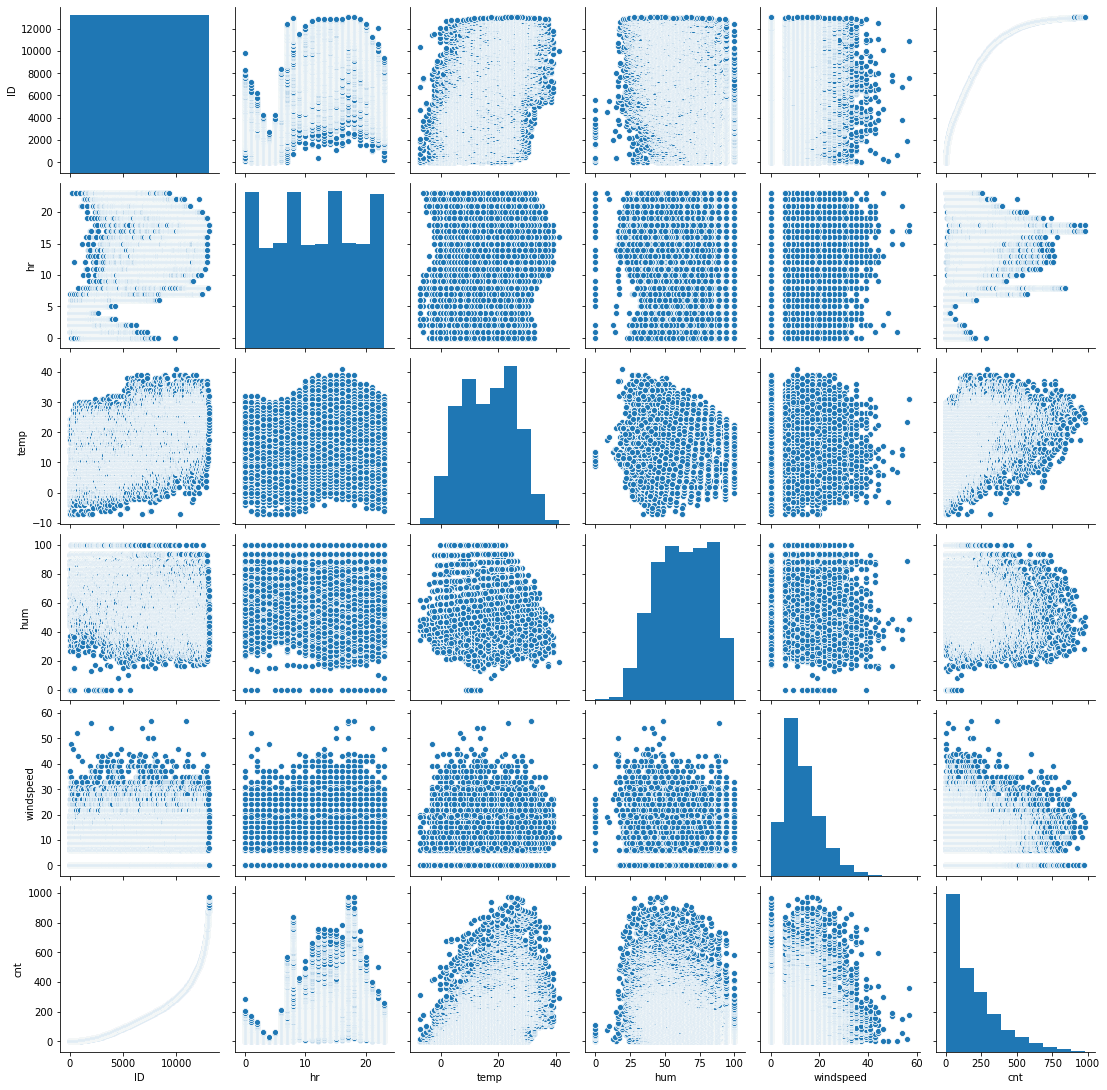

In [18]:
sns.pairplot(data)

In [20]:
spearmanr(data.ID,data.cnt)

SpearmanrResult(correlation=0.9999882087553265, pvalue=0.0)

$ \text{It is clear that cnt (the target variable)  increases when ID increases.} \\
\text{We dont know whether this is the case for the test data too .So,we are going to drop ID from the predictor space} $


<BarContainer object of 2 artists>

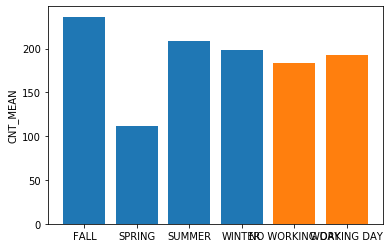

In [21]:
groups=data.groupby('season')['cnt']

plt.bar(groups.mean().index,groups.mean())


plt.ylabel('CNT_MEAN')

medians=groups.median()

groups1=data.groupby('workingday')['cnt']


medians1=groups1.median()
plt.bar(groups1.mean().index,groups1.mean())


In [22]:
medians

season
FALL      201
SPRING     76
SUMMER    164
WINTER    156
Name: cnt, dtype: int64

In [23]:
medians1

workingday
NO WORKING DAY    121
WORKING DAY       150
Name: cnt, dtype: int64

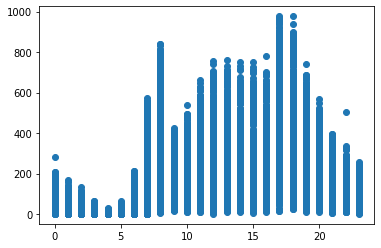

In [26]:
plt.scatter(data.hr,data.cnt)

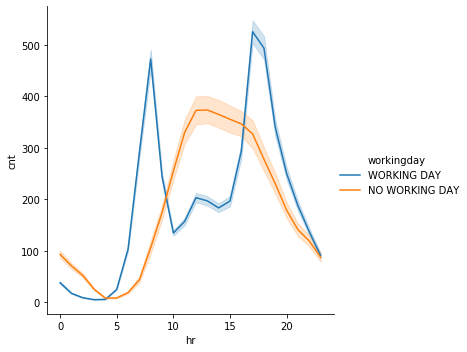

In [28]:
sns.relplot(data=data,x='hr',y='cnt',kind='line',hue='workingday')

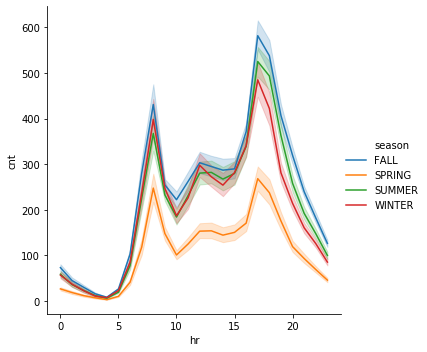

In [29]:
sns.relplot(data=data,x='hr',y='cnt',kind='line',hue='season')

$\text{Next we do some feature engineering}$

In [30]:
data['workinday1']=121*(data['workingday']=='NO WORKING DAY') + 150*(data['workingday']=='WORKING DAY')

data['season1'] =medians['FALL']*(data['season']=='FALL'  ) +
     medians['SPRING']* (data['season']=='SPRING' ) +medians['SUMMER']*( data['season']=='SUMMER' ) +
          medians['WINTER']*(data['season']=='WINTER')

data=data.drop(['workingday','season'],axis=1)
data=pd.get_dummies(data,['holiday','weekday','weathersit'])
data=data.drop(['ID'],axis=1)


In [31]:
data.shape

(13034, 19)

In [32]:
data.head()

,hr,temp,hum,windspeed,cnt,workinday1,season1,holiday_HOLIDAY,holiday_NO HOLIDAY,weekday_FRI,weekday_MON,weekday_SAT,weekday_SUN,weekday_THU,weekday_TUE,weekday_WED,weathersit_GOOD,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
0,3,24.34,89,0.0000,1,150,201,0,1,0,1,0,0,0,0,0,1,0,0
1,3,20.42,68,8.9981,1,150,201,0,1,0,0,0,0,0,0,1,1,0,0
2,3,18.46,94,19.9995,1,150,201,0,1,0,0,0,0,0,1,0,0,0,1
3,4,13.56,77,15.0013,1,121,201,0,1,0,0,0,1,0,0,0,1,0,0
4,5,22.38,83,12.9980,1,121,201,0,1,0,0,0,1,0,0,0,0,0,1


We proceed to creating predictive models.

In [33]:
X_train,X_test,y_train,y_test=train_test_split(data.drop(['cnt'],axis=1),data['cnt'],test_size=0.2 ,random_state=23)


$$ \huge{Random Forest Regression} $$

In [35]:
rf=RandomForestRegressor(n_estimators=500,max_features=12,criterion='mse')
rf.fit(X_train,y_train)
mse(rf.predict(X_train),y_train)
mse(rf.predict(X_test),y_test,squared=False)

68.5907410993643

$$\huge{XGBoost Rergression}$$

In [37]:
model=xgb.XGBRegressor()
params={"learning_rate":[0.001,0.01,0.05,0.1,0.2],"n_estimators":[800,100,1100,1300] ,"max_depth":[4,6,8,10]}

grs=GridSearchCV(model,params,n_jobs=2,
                 cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3,
                                        random_state=23),scoring='neg_mean_squared_error')


In [39]:
grs.fit(X_train,y_train)

C:\Users\billy\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\billy\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\billy\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[05:37:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=23),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthre...
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=2,
             param_grid={'learning_rate': [0.001, 0.01, 0.05, 0

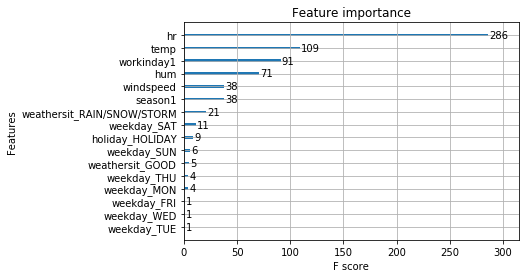

In [40]:
model=xgb.XGBRegressor(objective='reg:squarederror',params=grs.best_params_)
model.fit(X_train,y_train)
xgb.plot_importance(model)
 

In [43]:
mse(grs.predict(X_test),y_test,squared=False)

66.15244767271703

In [45]:
len(grs.predict(X_test)<0) 

2607

In [47]:
def newpred(pred) :
    npred=[]
    for p in pred :
        if p >=0 :
            npred.append(p)
        else :
            npred.append(0)
    return npred
    

In [49]:
newpred([1,-1,0,2,-5])

[1, 0, 0, 2, 0]

In [51]:
def rmse_cust(pred,y):
    return mse(newpred(pred),y,squared=False)

In [53]:
rmse_cust(grs.predict(X_test),y_test)

66.03585009725886

$$\huge{Gradient Boosting Machine}$$

In [54]:
gbm=GradientBoostingRegressor()

grs_gbm=GridSearchCV(gbm,params,n_jobs=2,
                 cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=23),scoring='neg_mean_squared_error')
grs_gbm.fit(X_train,y_train)
mse(grs_gbm.predict(X_test),y_test,squared=False)


C:\Users\billy\anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


66.38461749990297

In [56]:
rmse_cust(grs_gbm.predict(X_test),y_test)

66.2598904940824

$$\huge{Stacking Regression}$$

In [69]:
estimators=[('rf',RandomForestRegressor(n_estimators=500,max_features=12,criterion='mse',random_state=23))
    ,('gbm',GradientBoostingRegressor(n_estimators=1000,learning_rate=0.01, max_depth=8 )),
('xgb',xgb.XGBRegressor(objective='reg:squarederror',params={'n_estimators':800,'learning_rate':0.05,'max_depth':6}))]

In [70]:
stack=StackingRegressor(estimators,final_estimator=Ridge(),cv=5)

stack.fit(X_train,y_train)
mse(stack.predict( X_test),y_test,squared=False)

65.79454863228874

In [72]:


preds=stack.transform(X_train)
preds=pd.DataFrame(preds)
preds.corr()

,0,1,2
0,1.000000,0.991205,0.925285
1,0.991205,1.000000,0.937675
2,0.925285,0.937675,1.000000


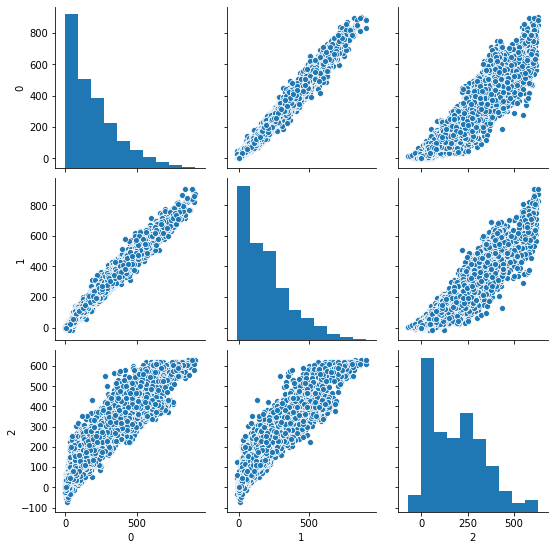

In [73]:
sns.pairplot(preds)

In [82]:
residuals=stack.predict(X_test)-y_test

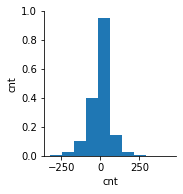

In [84]:
sns.pairplot(pd.DataFrame(residuals))

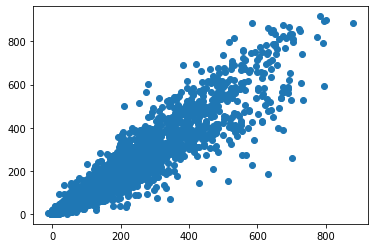

In [88]:
plt.scatter(stack.predict(X_test),y_test)